In [1]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

calibration_data = pickle.load(open('calibration_data.p','rb'))

matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
dest_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
inv_warp_matrix = cv2.getPerspectiveTransform(np.float32(dest_points), np.float32(source_points))

In [2]:
def show_dotted_image(this_image, points, color=[255,0,255], thickness=5, d=15):
    image = this_image.copy()
    image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cv2.line(image, points[0],points[1],color,thickness)
    cv2.line(image, points[2],points[3],color,thickness)
    
    circle_color = (30,120,180)
    for point in points:
        cv2.circle(image, point, d,circle_color,-1)

    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(image)
        
    plt.show()

def birdeye_sky_view(ground_image):
    temp_image = cv2.undistort(ground_image, matrix, dist_coef, None, matrix)
    shape = (temp_image.shape[1] ,temp_image.shape[0]) # (width,height)
    # 위쪽에 이미 구해놓았음
    # warp_matrix = cv2.getPerspectiveTransform(np.float32(source_points), np.float32(dest_points))
    warp_image = cv2.warpPerspective(temp_image, warp_matrix, shape, flags=cv2.INTER_LINEAR)
    
    return warp_image

### thresholding parameter 설정

In [3]:
# BGR -> HLS
# Yellow : sat_thresh : HLS에서 S threshold  / light_thresh : HLS에서 L threshold 
# White : light_thresh_agr : HLS에서 L threshold 
# Sobel에서 edge추출 
# grad_thresh : 기울기  / mag_thresh : 경계선의 값이 큰거 / x_thresh : x의 변동성
p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

sat_thresh = 120
light_thresh = 40
light_thresh_agr = 205
grad_min = 0.7; grad_max = 1.4
mag_thresh = 40
x_thresh = 20

In [4]:
import cv2
import numpy as np
def apply_color_mask(img_hls):   
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b = np.zeros_like(img_s)
    b[(color_cond1 | color_cond2)] = 1
    return b

def scale_abs(x, m=255):
    x = np.absolute(x)
    x = np.uint8(m * x / np.max(x))
    return x

def roi(gray, mn = 125, mx = 1200):
  m = np.copy(gray) + 1
  m[:, :mn] = 0 
  m[:, mx:] = 0 
  return m 

def show_images(imgs, per_row = 3, per_col = 2, W = 10, H = 5, tdpi = 80):
      
  fig, ax = plt.subplots(per_col, per_row, figsize = (W, H), dpi = tdpi)
  ax = ax.ravel()
  
  for i in range(len(imgs)):
    img = imgs[i]
    ax[i].imshow(img)
  
  for i in range(per_row * per_col):
    ax[i].axis('off')

def apply_sobel_mask(img_hls):
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    b = np.zeros_like(img_s)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b[(sobel_cond1 & sobel_cond2 & sobel_cond3)] = 1  
    return b 

def sobel_breakdown(img): #RGB
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]  
    img_z = np.zeros_like(img_s)     
    lx = cv2.Sobel(img_l, cv2.CV_64F, 1, 0, ksize = 5)
    ly = cv2.Sobel(img_l, cv2.CV_64F, 0, 1, ksize = 5)
    gradl = np.arctan2(np.absolute(ly), np.absolute(lx))
    l_mag = np.sqrt(lx**2 + ly**2)
    slm, slx, sly = scale_abs(l_mag), scale_abs(lx), scale_abs(ly)
    sobel_cond1 = slm > mag_thresh
    sobel_cond2 = slx > x_thresh
    sobel_cond3 = (gradl > grad_min) & (gradl < grad_max)
    b1, b2, b3 = img_z.copy(), img_z.copy(), img_z.copy()
    b1[(sobel_cond1)] = 255
    b2[(sobel_cond2)] = 255
    b3[(sobel_cond3)] = 255
    return np.dstack((b1, b2,b3))

def color_breakdown(rgb_image):
    img_hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    img_l = img_hls[:, :, 1]
    img_s = img_hls[:, :, 2]
    img_z = np.zeros_like(img_s)
    color_cond1 = (img_s > sat_thresh) & (img_l > light_thresh)
    color_cond2 = img_l > light_thresh_agr
    b1, b2 = img_z.copy(), img_z.copy()
    b1[(color_cond1)] = 255
    b2[(color_cond2)] = 255
    return np.dstack((b1, b2, img_z))


def lane_filter_test(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # BGR -> RGB
    img = cv2.undistort(img, matrix, dist_coef, None, matrix)
    #############################################################
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    color_img = apply_color_mask(img_hls)
    sobel_img = apply_sobel_mask(img_hls)
    img_binary = cv2.bitwise_or(sobel_img, color_img) # 0,1
    #img_binary = np.uint8(255 * img_binary)
    
    color_img = birdeye_sky_view(color_breakdown(img))
    sobel_img = birdeye_sky_view(sobel_breakdown(img))
    masked_lane = np.logical_and(birdeye_sky_view(img_binary), roi(img_binary))

    show_images([color_img, sobel_img, masked_lane], per_row = 3, per_col = 1, W = 15, H = 5)
    # cv2.imshow('bin',np.uint8(255 * img_binary))
    # cv2.imshow('color',cv2.cvtColor(color_img,cv2.COLOR_RGB2BGR))
    # cv2.waitKey()
    # cv2.destroyAllWindows()

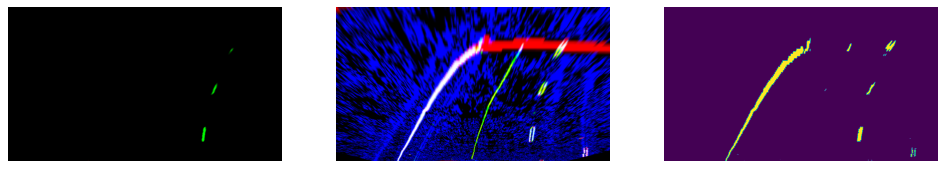

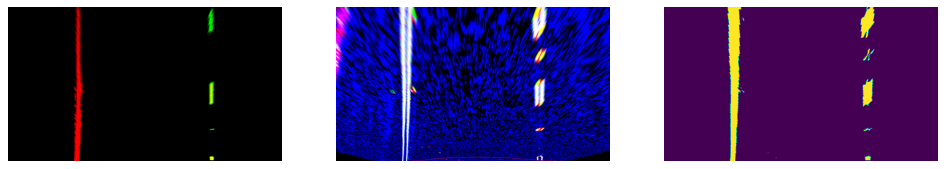

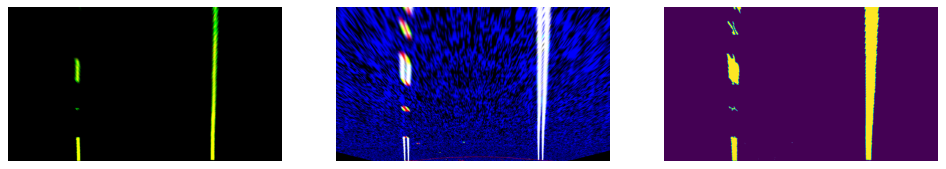

In [5]:
import glob

images = glob.glob('images/*.jpg')
tot_images = len(images)

for idx, fname in enumerate(images):
    lane_filter_test(fname)